In [1]:
# Load the data
import pandas as pd
train_df = pd.read_csv("../../cleaned_dataset/split_data/model_selection/train.csv")
test_df = pd.read_csv("../../cleaned_dataset/split_data/model_selection/test.csv")

In [2]:
# define the zone
zone_1_middle = ['kitchen', 'cafeteria', 'nurse station', 'cleaning'] 
zone_2_left = ['501', '502', '503', '505', '506', '513', '515', '516', '517'] 
zone_3_right = ['507', '508', '510', '511', '512', '518', '520', '521', '522', '523'] 

In [3]:
import numpy as np

# 1. Map rooms to Zones
def assign_zone(room):
    if room in zone_1_middle:
        return 'middle'
    elif room in zone_2_left:
        return 'left'
    elif room in zone_3_right:
        return 'right'
    else:
        return 'hallway' # Catch-all for the hallway if it exists in your data

train_df['Zone'] = train_df['room'].apply(assign_zone)
test_df['Zone'] = test_df['room'].apply(assign_zone)

# 2. Feature Vector Creation (25 Beacons)
def create_beacon_features(df):
    df = df.copy()
    # Ensure columns exist for all 25 beacons
    for i in range(1, 26):
        col_name = f'beacon_{i}'
        df[col_name] = df['RSSI'].where(df['mac address'] == i, 0)
    return df

train_processed = create_beacon_features(train_df)
test_processed = create_beacon_features(test_df)

# 3. Aggregation Function with Zone awareness
def aggregate_for_zones(df):
    # Using the standard aggregation logic but targeting the 'Zone' label
    agg_dict = {f'beacon_{i}': ['mean', 'std', 'max', 'min', 'count'] for i in range(1, 26)}
    agg_dict['Zone'] = 'first' # Keep the Zone label
    
    windowed = df.groupby('timestamp').agg(agg_dict)
    
    # Flatten columns
    windowed.columns = [f"{col[0]}_{col[1]}" if col[1] else col[0] for col in windowed.columns.values]
    windowed = windowed.rename(columns={'Zone_first': 'Zone'}).reset_index()
    
    # Fill NaNs from std calculation on single pulses
    windowed = windowed.fillna(0)
    
    # Filter out empty windows
    mean_cols = [f'beacon_{i}_mean' for i in range(1, 26)]
    windowed = windowed[windowed[mean_cols].sum(axis=1) != 0].reset_index(drop=True)
    
    return windowed

print("Aggregating windows for Zone Classification...")
windowed_train_zone = aggregate_for_zones(train_processed)
windowed_test_zone = aggregate_for_zones(test_processed)

print(f"Zone distribution in Train:\n{windowed_train_zone['Zone'].value_counts()}")

Aggregating windows for Zone Classification...
Zone distribution in Train:
Zone
middle     13535
right        760
hallway      620
left         177
Name: count, dtype: int64


STAGE 1: ZONE CLASSIFIER EVALUATION
              precision    recall  f1-score   support

     hallway       0.04      0.01      0.02       326
        left       0.92      0.52      0.67       450
      middle       0.88      0.97      0.92      4691
       right       0.84      0.68      0.75       509

    accuracy                           0.86      5976
   macro avg       0.67      0.55      0.59      5976
weighted avg       0.83      0.86      0.84      5976



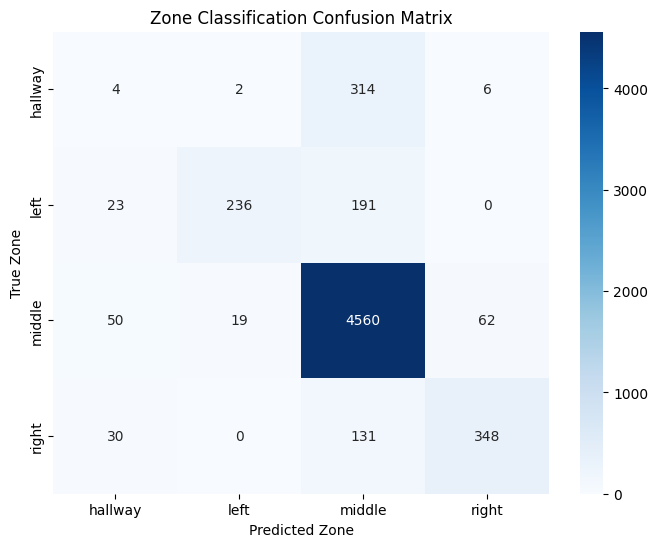

In [5]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt

# Encode the Zone labels (middle, left, right)
le = LabelEncoder()
y_train = le.fit_transform(windowed_train_zone['Zone'])
y_test = le.transform(windowed_test_zone['Zone'])

# Prepare features (Exclude timestamp and the label)
X_train = windowed_train_zone.drop(columns=['timestamp', 'Zone'])
X_test = windowed_test_zone.drop(columns=['timestamp', 'Zone'])

# Initialize and Train the Gatekeeper
zone_model = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    objective='multi:softprob',
    random_state=42,
    tree_method='hist' # Faster training
)

zone_model.fit(X_train, y_train)

# Predictions
y_pred = zone_model.predict(X_test)

# Results
print("==========================================================")
print("STAGE 1: ZONE CLASSIFIER EVALUATION")
print("==========================================================")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Confusion Matrix for Zones
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Zone Classification Confusion Matrix')
plt.xlabel('Predicted Zone')
plt.ylabel('True Zone')
plt.show()